In [1]:
!pip install -q evaluate
!pip install transformers -q
!pip install datasets -q

In [2]:
import pandas as pd
import numpy as np
import copy
import json
import torch
import time
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoConfig, AutoTokenizer, AutoModelForQuestionAnswering
from transformers import DataCollatorWithPadding, DefaultDataCollator
from torch.utils.data import DataLoader
from datasets import Dataset
from datasets import load_metric,load_dataset, Dataset, list_datasets
from transformers import AdamW
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from tqdm.notebook import tqdm
tqdm.pandas()
import torch.nn as nn
import torch.nn.functional as F
import gc
# from tqdm import tqdm
import os
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = "False"
from transformers import AutoModel, AutoConfig, AutoTokenizer, AutoModelForQuestionAnswering
from transformers import DataCollatorWithPadding, DefaultDataCollator
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
class Config:
    max_length = 384
    doc_stride = 128
    train_batch_size = 12
    valid_batch_size = 2*train_batch_size
    n_accumulate = 1
    n_folds = 5
    num_epochs = 1
    collate_fn = DefaultDataCollator()
    lr = 5e-6
    min_lr = 1e-6
    device = "cuda:0" if torch.cuda.is_available() else 'cpu'
    model_name = "deepset/deberta-v3-base-squad2"
    tokenizer = None
    
config = Config()
config.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

Downloading:   0%|          | 0.00/379 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [4]:
squad_metric = load_metric("squad_v2")
squad_val = load_dataset('squad_v2', split = "validation")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


In [5]:
squad_val

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})

In [6]:
squad_val.set_format("pandas")
df_pandas = squad_val.to_pandas()

In [7]:
df_pandas['answers'][0]

{'text': array(['France', 'France', 'France', 'France'], dtype=object),
 'answer_start': array([159, 159, 159, 159], dtype=int32)}

In [8]:
df_gen = pd.read_csv('/kaggle/input/new-qa-with-idx-squad-validation/new_qa_with_idx_squad_validation.csv')

In [9]:
for i in range(len(df_gen)):
        if (len(df_gen['Answer_text'][i]) == 0):
            df_gen['Answer_possible'].iloc[i] = 0
        else:
            df_gen['Answer_possible'].iloc[i] = 1

In [10]:
df_gen.insert(0, 'id', df_gen.index)

In [11]:
df_gen.rename(columns={df_gen.columns[0]:'id', 'Paragraph':'context',
                       'Question':'question',
                       'Answer_start':'answer_start',
                       'Answer_possible':'answer_possible'}, inplace=True)

In [12]:
new = []
for x in df_gen['Answer_text']:
        if x != '[]':
            new.append('['+x+']')
        else:
            new.append(x)
df_gen['answer'] = new

In [13]:
df_gen['answer_start'] = df_gen['answer_start'].apply(lambda x: [x])
df_gen['answer_end'] = (df_gen['answer_start'].apply(lambda x:x[0]) + df_gen['Answer_text'].apply(lambda x:len(x[0]) if len(x)>0 else 0)).apply(lambda x:[x])

In [14]:
def prepare_answer(row):
    if len(row['Answer_text']) == 0:
        out = {'text': '' , 'answer_start': row['answer_start'][0]}
    else:
        out = {'text': row['Answer_text'] , 'answer_start': row['answer_start'][0]}

    return out

df_gen = df_gen.assign(answers=df_gen.apply(prepare_answer , axis=1))

In [15]:
df_gen.head()

,id,Answer_text,question,context,answer_start,Theme,answer_possible,answer,answer_end,answers
0,0,Normandy,What did the Normans give their name to in the...,The Normans (Norman: Nourmands; French: Norman...,[137],Normans,1,[Normandy],[138],"{'text': 'Normandy', 'answer_start': 137}"
1,1,Norse,What language were the Normans descended from?,The Normans (Norman: Nourmands; French: Norman...,[192],Normans,1,[Norse],[193],"{'text': 'Norse', 'answer_start': 192}"
2,2,Carolingian,Along with the Frankish and Roman-Gaulish popu...,The Normans (Norman: Nourmands; French: Norman...,[527],Normans,1,[Carolingian],[528],"{'text': 'Carolingian', 'answer_start': 527}"
3,3,the first half of the 10th century,When did the distinct cultural and ethnic iden...,The Normans (Norman: Nourmands; French: Norman...,[649],Normans,1,[the first half of the 10th century],[650],"{'text': 'the first half of the 10th century',..."
4,4,The Norman dynasty,"Which dynasty had a major political, cultural ...","The Norman dynasty had a major political, cult...",[0],Normans,1,[The Norman dynasty],[1],"{'text': 'The Norman dynasty', 'answer_start': 0}"


In [16]:
df_pandas['title'].value_counts()

Economic_inequality                          515
Rhine                                        498
Warsaw                                       486
Immune_system                                458
Yuan_dynasty                                 445
Steam_engine                                 444
Huguenot                                     424
European_Union_law                           421
Computational_complexity_theory              418
Oxygen                                       415
French_and_Indian_War                        402
Islamism                                     384
Force                                        377
Packet_switching                             373
Imperialism                                  364
Geology                                      362
Scottish_Parliament                          357
University_of_Chicago                        356
Civil_disobedience                           327
Ctenophora                                   325
Southern_California 

In [17]:
df_pandas['title'].unique()

array(['Normans', 'Computational_complexity_theory',
       'Southern_California', 'Sky_(United_Kingdom)',
       'Victoria_(Australia)', 'Huguenot', 'Steam_engine', 'Oxygen',
       '1973_oil_crisis', 'European_Union_law', 'Amazon_rainforest',
       'Ctenophora', 'Fresno,_California', 'Packet_switching',
       'Black_Death', 'Geology', 'Pharmacy', 'Civil_disobedience',
       'Construction', 'Private_school', 'Harvard_University',
       'Jacksonville,_Florida', 'Economic_inequality',
       'University_of_Chicago', 'Yuan_dynasty', 'Immune_system',
       'Intergovernmental_Panel_on_Climate_Change', 'Prime_number',
       'Rhine', 'Scottish_Parliament', 'Islamism', 'Imperialism',
       'Warsaw', 'French_and_Indian_War', 'Force'], dtype=object)

In [18]:
themes = df_pandas['title'].unique()

In [19]:
score_df = pd.DataFrame(themes)

In [20]:
score_df_van = pd.DataFrame(themes)

In [21]:
score_df.insert(1, 'F1', 0)
score_df.insert(2, 'EM', 0)

In [22]:
score_df_van.insert(1, 'F1', 0)
score_df_van.insert(2, 'EM', 0)

In [23]:
def process_text(inp, tokenizer=config.tokenizer, config=config):
    tokenized_inp = tokenizer(inp['question'],
                             inp['context'],
                              add_special_tokens=True,
                             truncation='only_second',
                             max_length=config.max_length,
                             stride=config.doc_stride,
                             return_offsets_mapping=True,
                             return_overflowing_tokens=True,
                             padding='max_length',
                             return_token_type_ids=True)
    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_inp.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_inp.pop("offset_mapping")
    
    start_positions = []
    end_positions = []
    
    
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_inp["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_inp.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]

        # If no answers are given, set the cls_index as answer.
        if inp['answer_possible'][sample_index] == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = inp["answer_start"][sample_index][0]
            end_char = inp['answer_end'][sample_index][0]
            # print(start_char)

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)
    
    tokenized_inp["start_positions"] = start_positions
    tokenized_inp["end_positions"] = end_positions

    return tokenized_inp

In [24]:
class QA(nn.Module):
    def __init__(self):
        super(QA, self).__init__()
        self.model = AutoModelForQuestionAnswering.from_pretrained(config.model_name)

    def forward(self, ids, mask, token_type_ids):
        if config.model_name.split('-')[0]=='distilbert':
            out = self.model(ids, attention_mask=mask)
        else:
            out = self.model(ids, attention_mask=mask, token_type_ids=token_type_ids)
        return out.start_logits, out.end_logits

In [25]:
def criterion(out1, out2, inp1, inp2):
    l1 = nn.CrossEntropyLoss()(out1, inp1)
    l2 = nn.CrossEntropyLoss()(out2, inp2)
    return l1+l2

In [26]:
def train_epoch(model, data_loader, optimizer, scheduler, epoch, device):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for step, data in bar:
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        
        inp1 = data['start_positions'].to(device)
        inp2 = data['end_positions'].to(device)
        
        batch_size = ids.size(0)

        out1, out2 = model(ids, mask=mask, token_type_ids=token_type_ids)
        
        
        loss = criterion(out1, out2, inp1, inp2)
        loss = loss / config.n_accumulate
        loss.backward()
        
        del inp1,inp2,out1,out2        
    
        if (step + 1) % config.n_accumulate == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [27]:
def train(model, optimizer, scheduler, num_epochs, train_loader, fold, device):
    
    best_epoch_loss = np.inf
    best_model_wts = {}
    
    history = {'Train_loss':[], "Valid_loss":[]}
    
    for epoch in range(1, num_epochs+1):
        
        train_epoch_loss = train_epoch(model, train_loader, optimizer, scheduler, epoch, device)
        
#         valid_epoch_loss = valid_epoch(model, valid_loader, epoch, device)
        
        history['Train_loss'].append(train_epoch_loss)
#         history['Valid_loss'].append(valid_epoch_loss)
        
        
#         if valid_epoch_loss <= best_epoch_loss:
#             print(f"Validation Loss Improved ({best_epoch_loss} ---> {valid_epoch_loss})")
#             best_epoch_loss = valid_epoch_loss
#             # run.summary["Best Loss"] = best_epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"Loss-Fold-{fold}.bin"
        torch.save(model.state_dict(), PATH)
        print(f"Model Saved")

#     print("Best_epoch_loss: ",best_epoch_loss)
    
    model.state_dict(best_model_wts)
    
    return model, history

In [28]:
def optimizer_params(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    return optimizer_parameters

In [29]:
def evaluate(example):
    default = distil_model(question=example['question'], context=example['context'])
    return {
        'reference': {'id': example['id'], 'answers': example['answers']},
        'default': {'id': example['id'],'prediction_text': default['answer'], 'no_answer_probability': 0.}
      }

## Trained on Themes

In [30]:
for j in tqdm(range(len(themes))):
    
    df = df_pandas[df_pandas['title'] == themes[j]]
    df_gen1 = df_gen[df_gen['Theme']==themes[j]]
    df.insert(3,'answer_possible', 0)
    df.insert(4, 'Answer_text', 0)
    df.insert(5, 'Answer_start', 0)

    for i in range(len(df)):
        if (len(df['answers'].iloc[i]['answer_start']) == 0):
            continue
        else:
            df['answer_possible'].iloc[i] = 1

    for i in (range(len(df))):
        if (len(df['answers'].iloc[i]['answer_start']) == 0):
            df['Answer_text'].iloc[i] = '[]'
            df['Answer_start'].iloc[i] = 0
            continue
        else:
            df['Answer_text'].iloc[i] = df['answers'].iloc[i]['text'][0]
            df['Answer_start'].iloc[i] = df['answers'].iloc[i]['answer_start'][0]
    new = []
    for x in df['Answer_text']:
        if x != '[]':
            new.append('['+x+']')
        else:
            new.append(x)
    df['answer'] = new
    df['Answer_start'] = df['Answer_start'].apply(lambda x: [x])
    df['answer_end'] = (df['Answer_start'].apply(lambda x:x[0]) + df['Answer_text'].apply(lambda x:len(x[0]) if len(x)>0 else 0)).apply(lambda x:[x])
    df.rename(columns={df.columns[0]:'id', 'context':'context',
                       'question':'question',
                       'Answer_start':'answer_start',
                       'Answer_possible':'answer_possible'}, inplace=True)
    df['context'] = df['context'].apply(lambda t : t.strip())
    df = df.drop(['Answer_text'], axis=1)
    df = df.drop(['id'], axis = 1)
    df['id'] = df.index
    df.rename(columns={ 'title':'Theme'}, inplace=True)
#     df.append(df_gen1, ignore_index = True)

    df['fold'] = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    for i, (train_index, val_index) in enumerate(kf.split(df)):
        df.iloc[val_index]["fold"] = i

    train_df, val_df = train_test_split(df, test_size=0.7, stratify=df['fold'])
    train_df.append(df_gen1, ignore_index = True)
    pad_on_right = config.tokenizer.padding_side == "right"

    for fold in range(config.n_folds):
        df_train = train_df.reset_index(drop=True)
        train_dataset = Dataset.from_pandas(df_train).map(process_text, batched=True, remove_columns=list(df.columns))
        train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, collate_fn=config.collate_fn, 
                                      num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
        num_train_steps = int(len(train_dataset) / config.train_batch_size * config.num_epochs)
        model = QA()
        model.to(config.device)
        optimizer = AdamW(optimizer_params(model), lr=config.lr)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= (0.1 * num_train_steps), num_training_steps=num_train_steps)    
        model, history = train(model, 
                                   optimizer, 
                                   scheduler, 
                                   config.num_epochs, 
                                   train_loader, 
                                   fold, 
                                   device=config.device)
        torch.save(model.state_dict(), 'deberta_v3_new.pt')
        del history, train_loader 
        _ = gc.collect()
        print()
        break
        # Check if the directory exists
    if not os.path.exists("deberta_v3_new"):
            # Create the directory if it doesn't exist
        os.mkdir("deberta_v3_new")
    torch.save(model.state_dict(), f'deberta_v3_new/deberta_v3_new.pt')
    model = AutoModelForQuestionAnswering.from_pretrained("deepset/deberta-v3-base-squad2")
    tokenizer = AutoTokenizer.from_pretrained("deepset/deberta-v3-base-squad2")
    state_dict = torch.load(f'/kaggle/working/deberta_v3_new/deberta_v3_new.pt')
        # Create a new empty state dict
    new_state_dict = model.state_dict()
        # Remove the prefix 'model.' from the keys in the loaded state dict
    for key in list(state_dict.keys()):
        new_key = key.replace("model.","")
        new_state_dict[new_key] = state_dict[key]
        # Load the modified state dict into the model
    model.load_state_dict(new_state_dict)

    distil_model = pipeline("question-answering",model=model,tokenizer = tokenizer, handle_impossible_answer=True, device=0)
    results = val_df.progress_apply(evaluate, axis =1)

    predictions = []
    for i in range(len(results)):
        pred = results.iloc[i]['default']
        predictions.append(pred)
    references = []
    for i in (range(len(results))):
        ref = results.iloc[i]['reference']
        references.append(ref)
    default = squad_metric.compute(predictions=predictions, references=references)
    score_df['F1'][j] = default['f1']
    score_df['EM'][j] = default['exact']
    print(default)
    del model
    _ = gc.collect()
    
    model2 = AutoModelForQuestionAnswering.from_pretrained("deepset/deberta-v3-base-squad2")
    tokenizer2 = AutoTokenizer.from_pretrained("deepset/deberta-v3-base-squad2")

    distil_model = pipeline("question-answering",model=model2,tokenizer = tokenizer2, handle_impossible_answer=True, device=0)
    results = val_df.progress_apply(evaluate, axis =1)

    predictions = []
    for i in range(len(results)):
        pred = results.iloc[i]['default']
        predictions.append(pred)
    references = []
    for i in (range(len(results))):
        ref = results.iloc[i]['reference']
        references.append(ref)
    default = squad_metric.compute(predictions=predictions, references=references)
    score_df_van['F1'][j] = default['f1']
    score_df_van['EM'][j] = default['exact']
    print(default)
    _ = gc.collect()
#     if j == 5 : break

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/992 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701M [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/146 [00:00<?, ?it/s]

{'exact': 83.56164383561644, 'f1': 84.8744292237443, 'total': 146, 'HasAns_exact': 85.71428571428571, 'HasAns_f1': 88.45238095238095, 'HasAns_total': 70, 'NoAns_exact': 81.57894736842105, 'NoAns_f1': 81.57894736842105, 'NoAns_total': 76, 'best_exact': 83.56164383561644, 'best_exact_thresh': 0.0, 'best_f1': 84.8744292237443, 'best_f1_thresh': 0.0}


  0%|          | 0/146 [00:00<?, ?it/s]

{'exact': 82.1917808219178, 'f1': 83.50456621004567, 'total': 146, 'HasAns_exact': 84.28571428571429, 'HasAns_f1': 87.02380952380952, 'HasAns_total': 70, 'NoAns_exact': 80.26315789473684, 'NoAns_f1': 80.26315789473684, 'NoAns_total': 76, 'best_exact': 82.1917808219178, 'best_exact_thresh': 0.0, 'best_f1': 83.50456621004567, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/293 [00:00<?, ?it/s]

{'exact': 80.88737201365188, 'f1': 83.92999965525563, 'total': 293, 'HasAns_exact': 71.73913043478261, 'HasAns_f1': 78.19920216659348, 'HasAns_total': 138, 'NoAns_exact': 89.03225806451613, 'NoAns_f1': 89.03225806451613, 'NoAns_total': 155, 'best_exact': 80.88737201365188, 'best_exact_thresh': 0.0, 'best_f1': 83.92999965525563, 'best_f1_thresh': 0.0}


  0%|          | 0/293 [00:00<?, ?it/s]

{'exact': 79.18088737201366, 'f1': 83.10601135686458, 'total': 293, 'HasAns_exact': 68.1159420289855, 'HasAns_f1': 76.44971976493716, 'HasAns_total': 138, 'NoAns_exact': 89.03225806451613, 'NoAns_f1': 89.03225806451613, 'NoAns_total': 155, 'best_exact': 79.18088737201366, 'best_exact_thresh': 0.0, 'best_f1': 83.10601135686458, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/227 [00:00<?, ?it/s]

{'exact': 80.61674008810573, 'f1': 81.85022026431719, 'total': 227, 'HasAns_exact': 89.16666666666667, 'HasAns_f1': 91.5, 'HasAns_total': 120, 'NoAns_exact': 71.02803738317758, 'NoAns_f1': 71.02803738317758, 'NoAns_total': 107, 'best_exact': 80.61674008810573, 'best_exact_thresh': 0.0, 'best_f1': 81.85022026431719, 'best_f1_thresh': 0.0}


  0%|          | 0/227 [00:00<?, ?it/s]

{'exact': 78.8546255506608, 'f1': 80.75938745542268, 'total': 227, 'HasAns_exact': 89.16666666666667, 'HasAns_f1': 92.76984126984127, 'HasAns_total': 120, 'NoAns_exact': 67.28971962616822, 'NoAns_f1': 67.28971962616822, 'NoAns_total': 107, 'best_exact': 79.29515418502203, 'best_exact_thresh': 0.0, 'best_f1': 81.19991608978393, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/147 [00:00<?, ?it/s]

{'exact': 89.79591836734694, 'f1': 92.48107901169126, 'total': 147, 'HasAns_exact': 83.11688311688312, 'HasAns_f1': 88.24309889244952, 'HasAns_total': 77, 'NoAns_exact': 97.14285714285714, 'NoAns_f1': 97.14285714285714, 'NoAns_total': 70, 'best_exact': 89.79591836734694, 'best_exact_thresh': 0.0, 'best_f1': 92.48107901169126, 'best_f1_thresh': 0.0}


  0%|          | 0/147 [00:00<?, ?it/s]

{'exact': 88.43537414965986, 'f1': 91.12053479400417, 'total': 147, 'HasAns_exact': 80.51948051948052, 'HasAns_f1': 85.64569629504692, 'HasAns_total': 77, 'NoAns_exact': 97.14285714285714, 'NoAns_f1': 97.14285714285714, 'NoAns_total': 70, 'best_exact': 88.43537414965986, 'best_exact_thresh': 0.0, 'best_f1': 91.1205347940042, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/173 [00:00<?, ?it/s]

{'exact': 78.03468208092485, 'f1': 82.9587368315692, 'total': 173, 'HasAns_exact': 78.72340425531915, 'HasAns_f1': 87.78576033895185, 'HasAns_total': 94, 'NoAns_exact': 77.21518987341773, 'NoAns_f1': 77.21518987341773, 'NoAns_total': 79, 'best_exact': 78.03468208092485, 'best_exact_thresh': 0.0, 'best_f1': 82.9587368315692, 'best_f1_thresh': 0.0}


  0%|          | 0/173 [00:00<?, ?it/s]

{'exact': 78.03468208092485, 'f1': 82.9587368315692, 'total': 173, 'HasAns_exact': 78.72340425531915, 'HasAns_f1': 87.78576033895185, 'HasAns_total': 94, 'NoAns_exact': 77.21518987341773, 'NoAns_f1': 77.21518987341773, 'NoAns_total': 79, 'best_exact': 78.03468208092485, 'best_exact_thresh': 0.0, 'best_f1': 82.9587368315692, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/297 [00:00<?, ?it/s]

{'exact': 85.18518518518519, 'f1': 88.37226559448784, 'total': 297, 'HasAns_exact': 82.23684210526316, 'HasAns_f1': 88.46422948396632, 'HasAns_total': 152, 'NoAns_exact': 88.27586206896552, 'NoAns_f1': 88.27586206896552, 'NoAns_total': 145, 'best_exact': 85.18518518518519, 'best_exact_thresh': 0.0, 'best_f1': 88.37226559448781, 'best_f1_thresh': 0.0}


  0%|          | 0/297 [00:00<?, ?it/s]

{'exact': 84.84848484848484, 'f1': 88.0355652577875, 'total': 297, 'HasAns_exact': 83.55263157894737, 'HasAns_f1': 89.78001895765053, 'HasAns_total': 152, 'NoAns_exact': 86.20689655172414, 'NoAns_f1': 86.20689655172414, 'NoAns_total': 145, 'best_exact': 84.84848484848484, 'best_exact_thresh': 0.0, 'best_f1': 88.03556525778748, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/311 [00:00<?, ?it/s]

{'exact': 87.45980707395498, 'f1': 89.70678303475731, 'total': 311, 'HasAns_exact': 88.46153846153847, 'HasAns_f1': 92.9410866910867, 'HasAns_total': 156, 'NoAns_exact': 86.45161290322581, 'NoAns_f1': 86.45161290322581, 'NoAns_total': 155, 'best_exact': 87.45980707395498, 'best_exact_thresh': 0.0, 'best_f1': 89.70678303475734, 'best_f1_thresh': 0.0}


  0%|          | 0/311 [00:00<?, ?it/s]

{'exact': 83.60128617363344, 'f1': 86.13407849742254, 'total': 311, 'HasAns_exact': 89.1025641025641, 'HasAns_f1': 94.15191290191288, 'HasAns_total': 156, 'NoAns_exact': 78.06451612903226, 'NoAns_f1': 78.06451612903226, 'NoAns_total': 155, 'best_exact': 83.60128617363344, 'best_exact_thresh': 0.0, 'best_f1': 86.13407849742256, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/291 [00:00<?, ?it/s]

{'exact': 80.41237113402062, 'f1': 82.90259966638274, 'total': 291, 'HasAns_exact': 83.14606741573034, 'HasAns_f1': 87.21717136470436, 'HasAns_total': 178, 'NoAns_exact': 76.10619469026548, 'NoAns_f1': 76.10619469026548, 'NoAns_total': 113, 'best_exact': 80.41237113402062, 'best_exact_thresh': 0.0, 'best_f1': 82.90259966638274, 'best_f1_thresh': 0.0}


  0%|          | 0/291 [00:00<?, ?it/s]

{'exact': 79.38144329896907, 'f1': 82.10076690578708, 'total': 291, 'HasAns_exact': 81.46067415730337, 'HasAns_f1': 85.90630994148336, 'HasAns_total': 178, 'NoAns_exact': 76.10619469026548, 'NoAns_f1': 76.10619469026548, 'NoAns_total': 113, 'best_exact': 79.38144329896907, 'best_exact_thresh': 0.0, 'best_f1': 82.10076690578708, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/179 [00:00<?, ?it/s]

{'exact': 74.30167597765363, 'f1': 77.08839960565233, 'total': 179, 'HasAns_exact': 80.76923076923077, 'HasAns_f1': 87.16440422322775, 'HasAns_total': 78, 'NoAns_exact': 69.3069306930693, 'NoAns_f1': 69.3069306930693, 'NoAns_total': 101, 'best_exact': 74.30167597765363, 'best_exact_thresh': 0.0, 'best_f1': 77.08839960565234, 'best_f1_thresh': 0.0}


  0%|          | 0/179 [00:00<?, ?it/s]

{'exact': 74.30167597765363, 'f1': 77.08839960565233, 'total': 179, 'HasAns_exact': 82.05128205128206, 'HasAns_f1': 88.44645550527902, 'HasAns_total': 78, 'NoAns_exact': 68.31683168316832, 'NoAns_f1': 68.31683168316832, 'NoAns_total': 101, 'best_exact': 74.30167597765363, 'best_exact_thresh': 0.0, 'best_f1': 77.08839960565234, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/295 [00:00<?, ?it/s]

{'exact': 86.77966101694915, 'f1': 93.18949653955508, 'total': 295, 'HasAns_exact': 77.63975155279503, 'HasAns_f1': 89.38448123707292, 'HasAns_total': 161, 'NoAns_exact': 97.76119402985074, 'NoAns_f1': 97.76119402985074, 'NoAns_total': 134, 'best_exact': 86.77966101694915, 'best_exact_thresh': 0.0, 'best_f1': 93.18949653955508, 'best_f1_thresh': 0.0}


  0%|          | 0/295 [00:00<?, ?it/s]

{'exact': 86.77966101694915, 'f1': 93.08780162430082, 'total': 295, 'HasAns_exact': 77.63975155279503, 'HasAns_f1': 89.19814583334623, 'HasAns_total': 161, 'NoAns_exact': 97.76119402985074, 'NoAns_f1': 97.76119402985074, 'NoAns_total': 134, 'best_exact': 86.77966101694915, 'best_exact_thresh': 0.0, 'best_f1': 93.08780162430082, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/199 [00:00<?, ?it/s]

{'exact': 85.42713567839196, 'f1': 91.00193458710181, 'total': 199, 'HasAns_exact': 81.203007518797, 'HasAns_f1': 89.54424799122751, 'HasAns_total': 133, 'NoAns_exact': 93.93939393939394, 'NoAns_f1': 93.93939393939394, 'NoAns_total': 66, 'best_exact': 85.42713567839196, 'best_exact_thresh': 0.0, 'best_f1': 91.00193458710181, 'best_f1_thresh': 0.0}
{'exact': 85.92964824120602, 'f1': 91.50444714991588, 'total': 199, 'HasAns_exact': 81.95488721804512, 'HasAns_f1': 90.29612769047563, 'HasAns_total': 133, 'NoAns_exact': 93.93939393939394, 'NoAns_f1': 93.93939393939394, 'NoAns_total': 66, 'best_exact': 85.92964824120602, 'best_exact_thresh': 0.0, 'best_f1': 91.50444714991588, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/228 [00:00<?, ?it/s]

{'exact': 87.71929824561404, 'f1': 91.4420967749141, 'total': 228, 'HasAns_exact': 83.47826086956522, 'HasAns_f1': 90.85911360591669, 'HasAns_total': 115, 'NoAns_exact': 92.03539823008849, 'NoAns_f1': 92.03539823008849, 'NoAns_total': 113, 'best_exact': 87.71929824561404, 'best_exact_thresh': 0.0, 'best_f1': 91.44209677491415, 'best_f1_thresh': 0.0}


  0%|          | 0/228 [00:00<?, ?it/s]

{'exact': 87.71929824561404, 'f1': 91.4420967749141, 'total': 228, 'HasAns_exact': 84.34782608695652, 'HasAns_f1': 91.72867882330799, 'HasAns_total': 115, 'NoAns_exact': 91.15044247787611, 'NoAns_f1': 91.15044247787611, 'NoAns_total': 113, 'best_exact': 87.71929824561404, 'best_exact_thresh': 0.0, 'best_f1': 91.44209677491415, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/193 [00:00<?, ?it/s]

{'exact': 92.2279792746114, 'f1': 93.26424870466322, 'total': 193, 'HasAns_exact': 92.63157894736842, 'HasAns_f1': 94.73684210526316, 'HasAns_total': 95, 'NoAns_exact': 91.83673469387755, 'NoAns_f1': 91.83673469387755, 'NoAns_total': 98, 'best_exact': 92.2279792746114, 'best_exact_thresh': 0.0, 'best_f1': 93.26424870466322, 'best_f1_thresh': 0.0}


  0%|          | 0/193 [00:00<?, ?it/s]

{'exact': 91.70984455958549, 'f1': 92.74611398963731, 'total': 193, 'HasAns_exact': 93.6842105263158, 'HasAns_f1': 95.78947368421052, 'HasAns_total': 95, 'NoAns_exact': 89.79591836734694, 'NoAns_f1': 89.79591836734694, 'NoAns_total': 98, 'best_exact': 91.70984455958549, 'best_exact_thresh': 0.0, 'best_f1': 92.74611398963731, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/262 [00:00<?, ?it/s]

{'exact': 65.26717557251908, 'f1': 71.52095656199099, 'total': 262, 'HasAns_exact': 38.666666666666664, 'HasAns_f1': 60.513208256555224, 'HasAns_total': 75, 'NoAns_exact': 75.93582887700535, 'NoAns_f1': 75.93582887700535, 'NoAns_total': 187, 'best_exact': 72.51908396946565, 'best_exact_thresh': 0.0, 'best_f1': 74.94084136377971, 'best_f1_thresh': 0.0}


  0%|          | 0/262 [00:00<?, ?it/s]

{'exact': 60.30534351145038, 'f1': 67.06275435250669, 'total': 262, 'HasAns_exact': 37.333333333333336, 'HasAns_f1': 60.939221871423335, 'HasAns_total': 75, 'NoAns_exact': 69.5187165775401, 'NoAns_f1': 69.5187165775401, 'NoAns_total': 187, 'best_exact': 71.37404580152672, 'best_exact_thresh': 0.0, 'best_f1': 72.70147767403435, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/154 [00:00<?, ?it/s]

{'exact': 83.76623376623377, 'f1': 87.62416332242287, 'total': 154, 'HasAns_exact': 76.62337662337663, 'HasAns_f1': 84.33923573575483, 'HasAns_total': 77, 'NoAns_exact': 90.9090909090909, 'NoAns_f1': 90.9090909090909, 'NoAns_total': 77, 'best_exact': 83.76623376623377, 'best_exact_thresh': 0.0, 'best_f1': 87.62416332242289, 'best_f1_thresh': 0.0}


  0%|          | 0/154 [00:00<?, ?it/s]

{'exact': 85.06493506493507, 'f1': 88.92286462112416, 'total': 154, 'HasAns_exact': 79.22077922077922, 'HasAns_f1': 86.93663833315742, 'HasAns_total': 77, 'NoAns_exact': 90.9090909090909, 'NoAns_f1': 90.9090909090909, 'NoAns_total': 77, 'best_exact': 85.06493506493507, 'best_exact_thresh': 0.0, 'best_f1': 88.92286462112418, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/254 [00:00<?, ?it/s]

{'exact': 86.22047244094489, 'f1': 89.10315222374899, 'total': 254, 'HasAns_exact': 78.3132530120482, 'HasAns_f1': 87.13494776906317, 'HasAns_total': 83, 'NoAns_exact': 90.05847953216374, 'NoAns_f1': 90.05847953216374, 'NoAns_total': 171, 'best_exact': 86.22047244094489, 'best_exact_thresh': 0.0, 'best_f1': 89.10315222374899, 'best_f1_thresh': 0.0}


  0%|          | 0/254 [00:00<?, ?it/s]

{'exact': 86.22047244094489, 'f1': 89.10315222374899, 'total': 254, 'HasAns_exact': 78.3132530120482, 'HasAns_f1': 87.13494776906317, 'HasAns_total': 83, 'NoAns_exact': 90.05847953216374, 'NoAns_f1': 90.05847953216374, 'NoAns_total': 171, 'best_exact': 86.22047244094489, 'best_exact_thresh': 0.0, 'best_f1': 89.10315222374899, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/171 [00:00<?, ?it/s]

{'exact': 84.21052631578948, 'f1': 90.26977487079353, 'total': 171, 'HasAns_exact': 74.19354838709677, 'HasAns_f1': 85.33474734307202, 'HasAns_total': 93, 'NoAns_exact': 96.15384615384616, 'NoAns_f1': 96.15384615384616, 'NoAns_total': 78, 'best_exact': 84.21052631578948, 'best_exact_thresh': 0.0, 'best_f1': 90.26977487079354, 'best_f1_thresh': 0.0}


  0%|          | 0/171 [00:00<?, ?it/s]

{'exact': 84.21052631578948, 'f1': 90.43685924840425, 'total': 171, 'HasAns_exact': 74.19354838709677, 'HasAns_f1': 85.64196700513038, 'HasAns_total': 93, 'NoAns_exact': 96.15384615384616, 'NoAns_f1': 96.15384615384616, 'NoAns_total': 78, 'best_exact': 84.21052631578948, 'best_exact_thresh': 0.0, 'best_f1': 90.43685924840425, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/229 [00:00<?, ?it/s]

{'exact': 71.17903930131004, 'f1': 76.76372438693886, 'total': 229, 'HasAns_exact': 58.273381294964025, 'HasAns_f1': 67.47404952956113, 'HasAns_total': 139, 'NoAns_exact': 91.11111111111111, 'NoAns_f1': 91.11111111111111, 'NoAns_total': 90, 'best_exact': 71.17903930131004, 'best_exact_thresh': 0.0, 'best_f1': 76.76372438693885, 'best_f1_thresh': 0.0}


  0%|          | 0/229 [00:00<?, ?it/s]

{'exact': 70.74235807860262, 'f1': 75.80302569698253, 'total': 229, 'HasAns_exact': 57.55395683453237, 'HasAns_f1': 65.89131571661149, 'HasAns_total': 139, 'NoAns_exact': 91.11111111111111, 'NoAns_f1': 91.11111111111111, 'NoAns_total': 90, 'best_exact': 70.74235807860262, 'best_exact_thresh': 0.0, 'best_f1': 75.80302569698253, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/163 [00:00<?, ?it/s]

{'exact': 90.79754601226993, 'f1': 92.71983640081798, 'total': 163, 'HasAns_exact': 93.24324324324324, 'HasAns_f1': 97.47747747747746, 'HasAns_total': 74, 'NoAns_exact': 88.76404494382022, 'NoAns_f1': 88.76404494382022, 'NoAns_total': 89, 'best_exact': 90.79754601226993, 'best_exact_thresh': 0.0, 'best_f1': 92.71983640081798, 'best_f1_thresh': 0.0}


  0%|          | 0/163 [00:00<?, ?it/s]

{'exact': 88.34355828220859, 'f1': 90.76573506021359, 'total': 163, 'HasAns_exact': 91.89189189189189, 'HasAns_f1': 97.22722722722723, 'HasAns_total': 74, 'NoAns_exact': 85.3932584269663, 'NoAns_f1': 85.3932584269663, 'NoAns_total': 89, 'best_exact': 88.34355828220859, 'best_exact_thresh': 0.0, 'best_f1': 90.76573506021359, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/168 [00:00<?, ?it/s]

{'exact': 83.33333333333333, 'f1': 87.10600907029477, 'total': 168, 'HasAns_exact': 79.48717948717949, 'HasAns_f1': 87.61294261294262, 'HasAns_total': 78, 'NoAns_exact': 86.66666666666667, 'NoAns_f1': 86.66666666666667, 'NoAns_total': 90, 'best_exact': 83.33333333333333, 'best_exact_thresh': 0.0, 'best_f1': 87.1060090702948, 'best_f1_thresh': 0.0}


  0%|          | 0/168 [00:00<?, ?it/s]

{'exact': 83.33333333333333, 'f1': 87.10600907029477, 'total': 168, 'HasAns_exact': 79.48717948717949, 'HasAns_f1': 87.61294261294262, 'HasAns_total': 78, 'NoAns_exact': 86.66666666666667, 'NoAns_f1': 86.66666666666667, 'NoAns_total': 90, 'best_exact': 83.33333333333333, 'best_exact_thresh': 0.0, 'best_f1': 87.1060090702948, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/184 [00:00<?, ?it/s]

{'exact': 91.30434782608695, 'f1': 93.83772628337847, 'total': 184, 'HasAns_exact': 84.21052631578948, 'HasAns_f1': 90.34396889660047, 'HasAns_total': 76, 'NoAns_exact': 96.29629629629629, 'NoAns_f1': 96.29629629629629, 'NoAns_total': 108, 'best_exact': 91.30434782608695, 'best_exact_thresh': 0.0, 'best_f1': 93.83772628337844, 'best_f1_thresh': 0.0}


  0%|          | 0/184 [00:00<?, ?it/s]

{'exact': 91.30434782608695, 'f1': 93.50327812284335, 'total': 184, 'HasAns_exact': 85.52631578947368, 'HasAns_f1': 90.8500417710944, 'HasAns_total': 76, 'NoAns_exact': 95.37037037037037, 'NoAns_f1': 95.37037037037037, 'NoAns_total': 108, 'best_exact': 91.30434782608695, 'best_exact_thresh': 0.0, 'best_f1': 93.50327812284333, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/135 [00:00<?, ?it/s]

{'exact': 86.66666666666667, 'f1': 90.87397787397788, 'total': 135, 'HasAns_exact': 80.88235294117646, 'HasAns_f1': 89.23510313216195, 'HasAns_total': 68, 'NoAns_exact': 92.53731343283582, 'NoAns_f1': 92.53731343283582, 'NoAns_total': 67, 'best_exact': 86.66666666666667, 'best_exact_thresh': 0.0, 'best_f1': 90.87397787397789, 'best_f1_thresh': 0.0}


  0%|          | 0/135 [00:00<?, ?it/s]

{'exact': 86.66666666666667, 'f1': 90.87397787397788, 'total': 135, 'HasAns_exact': 80.88235294117646, 'HasAns_f1': 89.23510313216195, 'HasAns_total': 68, 'NoAns_exact': 92.53731343283582, 'NoAns_f1': 92.53731343283582, 'NoAns_total': 67, 'best_exact': 86.66666666666667, 'best_exact_thresh': 0.0, 'best_f1': 90.87397787397789, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/361 [00:00<?, ?it/s]

{'exact': 83.93351800554017, 'f1': 88.97100003177893, 'total': 361, 'HasAns_exact': 77.14285714285714, 'HasAns_f1': 85.80252862605803, 'HasAns_total': 210, 'NoAns_exact': 93.37748344370861, 'NoAns_f1': 93.37748344370861, 'NoAns_total': 151, 'best_exact': 83.93351800554017, 'best_exact_thresh': 0.0, 'best_f1': 88.97100003177897, 'best_f1_thresh': 0.0}


  0%|          | 0/361 [00:00<?, ?it/s]

{'exact': 83.37950138504155, 'f1': 88.37543216474292, 'total': 361, 'HasAns_exact': 76.66666666666667, 'HasAns_f1': 85.25490957843898, 'HasAns_total': 210, 'NoAns_exact': 92.71523178807946, 'NoAns_f1': 92.71523178807946, 'NoAns_total': 151, 'best_exact': 83.37950138504155, 'best_exact_thresh': 0.0, 'best_f1': 88.37543216474295, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/250 [00:00<?, ?it/s]

{'exact': 90.4, 'f1': 91.80115942028986, 'total': 250, 'HasAns_exact': 91.40625, 'HasAns_f1': 94.14288949275361, 'HasAns_total': 128, 'NoAns_exact': 89.34426229508196, 'NoAns_f1': 89.34426229508196, 'NoAns_total': 122, 'best_exact': 90.8, 'best_exact_thresh': 0.0, 'best_f1': 92.20115942028986, 'best_f1_thresh': 0.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'exact': 90.4, 'f1': 91.80115942028986, 'total': 250, 'HasAns_exact': 91.40625, 'HasAns_f1': 94.14288949275361, 'HasAns_total': 128, 'NoAns_exact': 89.34426229508196, 'NoAns_f1': 89.34426229508196, 'NoAns_total': 122, 'best_exact': 90.8, 'best_exact_thresh': 0.0, 'best_f1': 92.20115942028986, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/312 [00:00<?, ?it/s]

{'exact': 77.88461538461539, 'f1': 82.78535566997105, 'total': 312, 'HasAns_exact': 70.70063694267516, 'HasAns_f1': 80.43968770083418, 'HasAns_total': 157, 'NoAns_exact': 85.16129032258064, 'NoAns_f1': 85.16129032258064, 'NoAns_total': 155, 'best_exact': 77.88461538461539, 'best_exact_thresh': 0.0, 'best_f1': 82.78535566997108, 'best_f1_thresh': 0.0}


  0%|          | 0/312 [00:00<?, ?it/s]

{'exact': 77.88461538461539, 'f1': 82.68920182381721, 'total': 312, 'HasAns_exact': 71.97452229299363, 'HasAns_f1': 81.5224902486049, 'HasAns_total': 157, 'NoAns_exact': 83.87096774193549, 'NoAns_f1': 83.87096774193549, 'NoAns_total': 155, 'best_exact': 77.88461538461539, 'best_exact_thresh': 0.0, 'best_f1': 82.68920182381721, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/321 [00:00<?, ?it/s]

{'exact': 94.0809968847352, 'f1': 96.13349613349617, 'total': 321, 'HasAns_exact': 89.33333333333333, 'HasAns_f1': 93.72568172568171, 'HasAns_total': 150, 'NoAns_exact': 98.24561403508773, 'NoAns_f1': 98.24561403508773, 'NoAns_total': 171, 'best_exact': 94.0809968847352, 'best_exact_thresh': 0.0, 'best_f1': 96.13349613349612, 'best_f1_thresh': 0.0}


  0%|          | 0/321 [00:00<?, ?it/s]

{'exact': 94.0809968847352, 'f1': 96.30656640002437, 'total': 321, 'HasAns_exact': 89.33333333333333, 'HasAns_f1': 94.09605209605206, 'HasAns_total': 150, 'NoAns_exact': 98.24561403508773, 'NoAns_f1': 98.24561403508773, 'NoAns_total': 171, 'best_exact': 94.0809968847352, 'best_exact_thresh': 0.0, 'best_f1': 96.30656640002435, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/156 [00:00<?, ?it/s]

{'exact': 76.92307692307692, 'f1': 83.66046535164182, 'total': 156, 'HasAns_exact': 67.14285714285714, 'HasAns_f1': 82.15760849794462, 'HasAns_total': 70, 'NoAns_exact': 84.88372093023256, 'NoAns_f1': 84.88372093023256, 'NoAns_total': 86, 'best_exact': 76.92307692307692, 'best_exact_thresh': 0.0, 'best_f1': 83.66046535164185, 'best_f1_thresh': 0.0}


  0%|          | 0/156 [00:00<?, ?it/s]

{'exact': 76.92307692307692, 'f1': 83.66046535164182, 'total': 156, 'HasAns_exact': 67.14285714285714, 'HasAns_f1': 82.15760849794462, 'HasAns_total': 70, 'NoAns_exact': 84.88372093023256, 'NoAns_f1': 84.88372093023256, 'NoAns_total': 86, 'best_exact': 76.92307692307692, 'best_exact_thresh': 0.0, 'best_f1': 83.66046535164185, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/216 [00:00<?, ?it/s]

{'exact': 85.64814814814815, 'f1': 89.69778806584362, 'total': 216, 'HasAns_exact': 80.73394495412845, 'HasAns_f1': 88.75891946992863, 'HasAns_total': 109, 'NoAns_exact': 90.65420560747664, 'NoAns_f1': 90.65420560747664, 'NoAns_total': 107, 'best_exact': 85.64814814814815, 'best_exact_thresh': 0.0, 'best_f1': 89.69778806584361, 'best_f1_thresh': 0.0}


  0%|          | 0/216 [00:00<?, ?it/s]

{'exact': 85.18518518518519, 'f1': 89.15766460905351, 'total': 216, 'HasAns_exact': 81.65137614678899, 'HasAns_f1': 89.52344546381241, 'HasAns_total': 109, 'NoAns_exact': 88.78504672897196, 'NoAns_f1': 88.78504672897196, 'NoAns_total': 107, 'best_exact': 85.18518518518519, 'best_exact_thresh': 0.0, 'best_f1': 89.1576646090535, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/349 [00:00<?, ?it/s]

{'exact': 79.65616045845272, 'f1': 85.07595397280211, 'total': 349, 'HasAns_exact': 70.33492822966507, 'HasAns_f1': 79.38520543783703, 'HasAns_total': 209, 'NoAns_exact': 93.57142857142857, 'NoAns_f1': 93.57142857142857, 'NoAns_total': 140, 'best_exact': 79.65616045845272, 'best_exact_thresh': 0.0, 'best_f1': 85.07595397280208, 'best_f1_thresh': 0.0}


  0%|          | 0/349 [00:00<?, ?it/s]

{'exact': 80.80229226361031, 'f1': 85.86141811070178, 'total': 349, 'HasAns_exact': 72.72727272727273, 'HasAns_f1': 81.1752867016025, 'HasAns_total': 209, 'NoAns_exact': 92.85714285714286, 'NoAns_f1': 92.85714285714286, 'NoAns_total': 140, 'best_exact': 80.80229226361031, 'best_exact_thresh': 0.0, 'best_f1': 85.86141811070173, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/250 [00:00<?, ?it/s]

{'exact': 86.8, 'f1': 93.13173271173272, 'total': 250, 'HasAns_exact': 75.57251908396947, 'HasAns_f1': 87.65597845750517, 'HasAns_total': 131, 'NoAns_exact': 99.15966386554622, 'NoAns_f1': 99.15966386554622, 'NoAns_total': 119, 'best_exact': 86.8, 'best_exact_thresh': 0.0, 'best_f1': 93.13173271173271, 'best_f1_thresh': 0.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'exact': 86.0, 'f1': 91.91839937839939, 'total': 250, 'HasAns_exact': 74.04580152671755, 'HasAns_f1': 85.34045682900644, 'HasAns_total': 131, 'NoAns_exact': 99.15966386554622, 'NoAns_f1': 99.15966386554622, 'NoAns_total': 119, 'best_exact': 86.0, 'best_exact_thresh': 0.0, 'best_f1': 91.91839937839939, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/269 [00:00<?, ?it/s]

{'exact': 87.73234200743494, 'f1': 91.6422363262512, 'total': 269, 'HasAns_exact': 82.57575757575758, 'HasAns_f1': 90.543648270921, 'HasAns_total': 132, 'NoAns_exact': 92.7007299270073, 'NoAns_f1': 92.7007299270073, 'NoAns_total': 137, 'best_exact': 87.73234200743494, 'best_exact_thresh': 0.0, 'best_f1': 91.6422363262512, 'best_f1_thresh': 0.0}


  0%|          | 0/269 [00:00<?, ?it/s]

{'exact': 87.73234200743494, 'f1': 91.6422363262512, 'total': 269, 'HasAns_exact': 82.57575757575758, 'HasAns_f1': 90.543648270921, 'HasAns_total': 132, 'NoAns_exact': 92.7007299270073, 'NoAns_f1': 92.7007299270073, 'NoAns_total': 137, 'best_exact': 87.73234200743494, 'best_exact_thresh': 0.0, 'best_f1': 91.6422363262512, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/255 [00:00<?, ?it/s]

{'exact': 82.3529411764706, 'f1': 85.1172792349263, 'total': 255, 'HasAns_exact': 75.73529411764706, 'HasAns_f1': 80.91842797725151, 'HasAns_total': 136, 'NoAns_exact': 89.91596638655462, 'NoAns_f1': 89.91596638655462, 'NoAns_total': 119, 'best_exact': 82.3529411764706, 'best_exact_thresh': 0.0, 'best_f1': 85.1172792349263, 'best_f1_thresh': 0.0}


  0%|          | 0/255 [00:00<?, ?it/s]

{'exact': 83.52941176470588, 'f1': 86.83200434065488, 'total': 255, 'HasAns_exact': 79.41176470588235, 'HasAns_f1': 85.60412578578668, 'HasAns_total': 136, 'NoAns_exact': 88.23529411764706, 'NoAns_f1': 88.23529411764706, 'NoAns_total': 119, 'best_exact': 83.52941176470588, 'best_exact_thresh': 0.0, 'best_f1': 86.83200434065488, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/341 [00:00<?, ?it/s]

{'exact': 88.56304985337243, 'f1': 91.8205092398641, 'total': 341, 'HasAns_exact': 86.1271676300578, 'HasAns_f1': 92.54794017799796, 'HasAns_total': 173, 'NoAns_exact': 91.07142857142857, 'NoAns_f1': 91.07142857142857, 'NoAns_total': 168, 'best_exact': 88.56304985337243, 'best_exact_thresh': 0.0, 'best_f1': 91.8205092398641, 'best_f1_thresh': 0.0}


  0%|          | 0/341 [00:00<?, ?it/s]

{'exact': 86.80351906158357, 'f1': 90.6719266396686, 'total': 341, 'HasAns_exact': 84.39306358381504, 'HasAns_f1': 92.01807505275713, 'HasAns_total': 173, 'NoAns_exact': 89.28571428571429, 'NoAns_f1': 89.28571428571429, 'NoAns_total': 168, 'best_exact': 86.80351906158357, 'best_exact_thresh': 0.0, 'best_f1': 90.6719266396686, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/282 [00:00<?, ?it/s]

{'exact': 79.43262411347517, 'f1': 84.65763411407471, 'total': 282, 'HasAns_exact': 67.5, 'HasAns_f1': 79.77877350140889, 'HasAns_total': 120, 'NoAns_exact': 88.27160493827161, 'NoAns_f1': 88.27160493827161, 'NoAns_total': 162, 'best_exact': 79.7872340425532, 'best_exact_thresh': 0.0, 'best_f1': 85.01224404315273, 'best_f1_thresh': 0.0}


  0%|          | 0/282 [00:00<?, ?it/s]

{'exact': 79.43262411347517, 'f1': 84.40010320573028, 'total': 282, 'HasAns_exact': 70.0, 'HasAns_f1': 81.67357586679948, 'HasAns_total': 120, 'NoAns_exact': 86.41975308641975, 'NoAns_f1': 86.41975308641975, 'NoAns_total': 162, 'best_exact': 79.7872340425532, 'best_exact_thresh': 0.0, 'best_f1': 84.7547131348083, 'best_f1_thresh': 0.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/264 [00:00<?, ?it/s]

{'exact': 79.16666666666667, 'f1': 82.96973544132634, 'total': 264, 'HasAns_exact': 69.33333333333333, 'HasAns_f1': 76.02673437673438, 'HasAns_total': 150, 'NoAns_exact': 92.10526315789474, 'NoAns_f1': 92.10526315789474, 'NoAns_total': 114, 'best_exact': 79.54545454545455, 'best_exact_thresh': 0.0, 'best_f1': 83.34852332011423, 'best_f1_thresh': 0.0}


  0%|          | 0/264 [00:00<?, ?it/s]

{'exact': 79.16666666666667, 'f1': 82.96973544132634, 'total': 264, 'HasAns_exact': 69.33333333333333, 'HasAns_f1': 76.02673437673438, 'HasAns_total': 150, 'NoAns_exact': 92.10526315789474, 'NoAns_f1': 92.10526315789474, 'NoAns_total': 114, 'best_exact': 79.54545454545455, 'best_exact_thresh': 0.0, 'best_f1': 83.34852332011423, 'best_f1_thresh': 0.0}


In [31]:
score_df

,0,F1,EM
0,Normans,84,83
1,Computational_complexity_theory,83,80
2,Southern_California,81,80
3,Sky_(United_Kingdom),92,89
4,Victoria_(Australia),82,78
5,Huguenot,88,85
6,Steam_engine,89,87
7,Oxygen,82,80
8,1973_oil_crisis,77,74
9,European_Union_law,93,86


In [32]:
score_df.to_csv('final_score_df.csv', index = False, encoding='utf-8')

In [33]:
import matplotlib.pyplot as plt

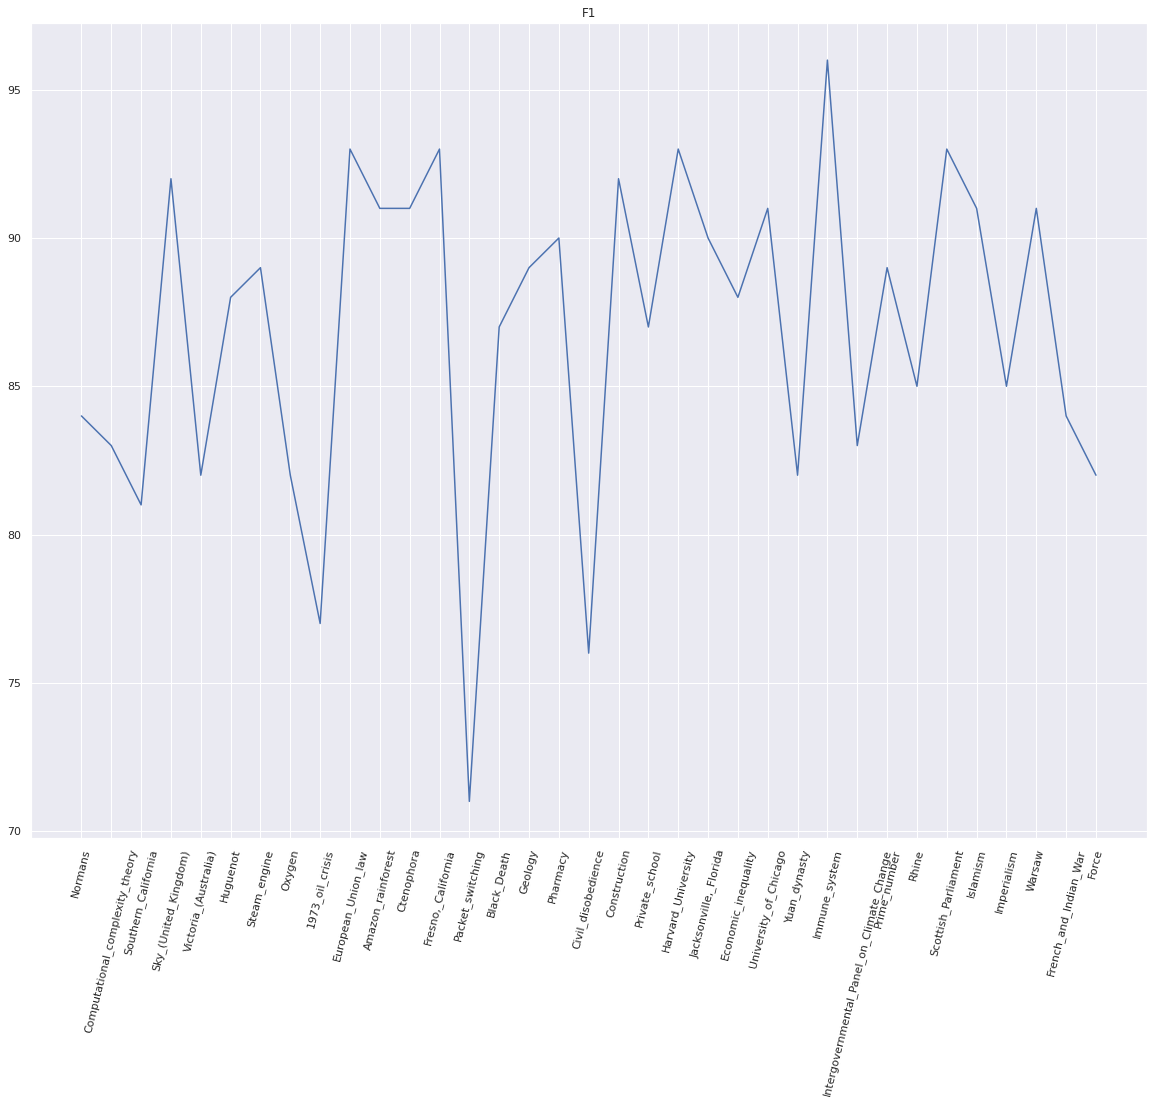

In [34]:
sns.set()
plt.title("F1")
x = score_df[0]
y = score_df['F1']
plt.plot(x, y)
plt.xticks(rotation=76)
# score_df['F1'].plot()
plt.gcf().set_size_inches(20, 15)
# plt.label

<AxesSubplot:title={'center':'EM'}, ylabel='EM'>

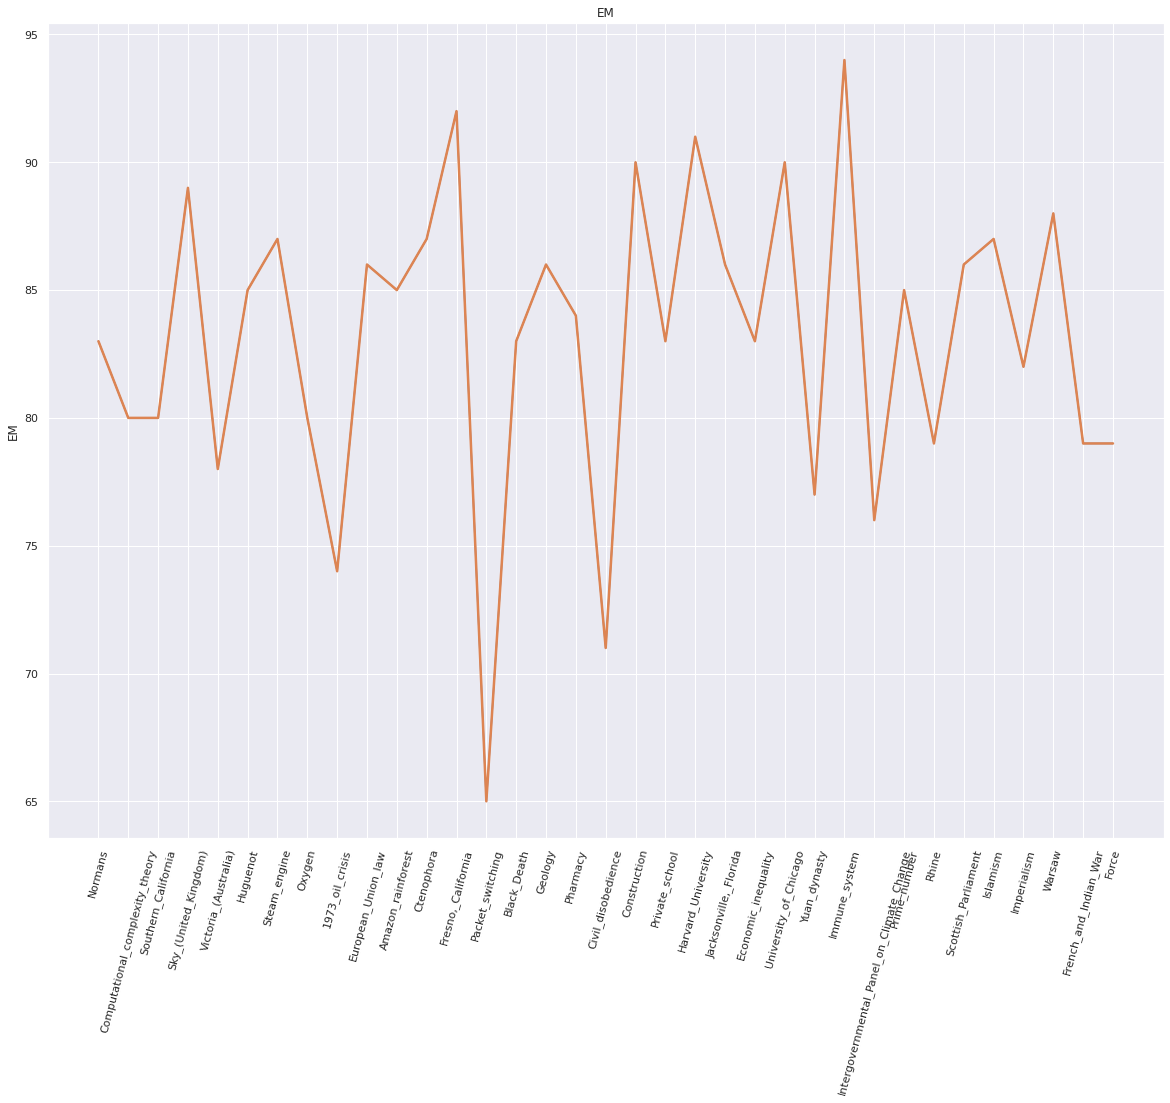

In [35]:
sns.set()
plt.title("EM")
x = score_df[0]
y = score_df['EM']
# score_df['EM'].plot()
plt.plot(x, y)
plt.xticks(rotation=75)
plt.gcf().set_size_inches(20, 15)
sns.lineplot(data=y, palette=['r'], linewidth=2.5)

In [38]:
score_df_van

,0,F1,EM
0,Normans,83,82
1,Computational_complexity_theory,83,79
2,Southern_California,80,78
3,Sky_(United_Kingdom),91,88
4,Victoria_(Australia),82,78
5,Huguenot,88,84
6,Steam_engine,86,83
7,Oxygen,82,79
8,1973_oil_crisis,77,74
9,European_Union_law,93,86


In [39]:
score_df_van.to_csv('70_30_score_van_df.csv', index = False, encoding='utf-8')

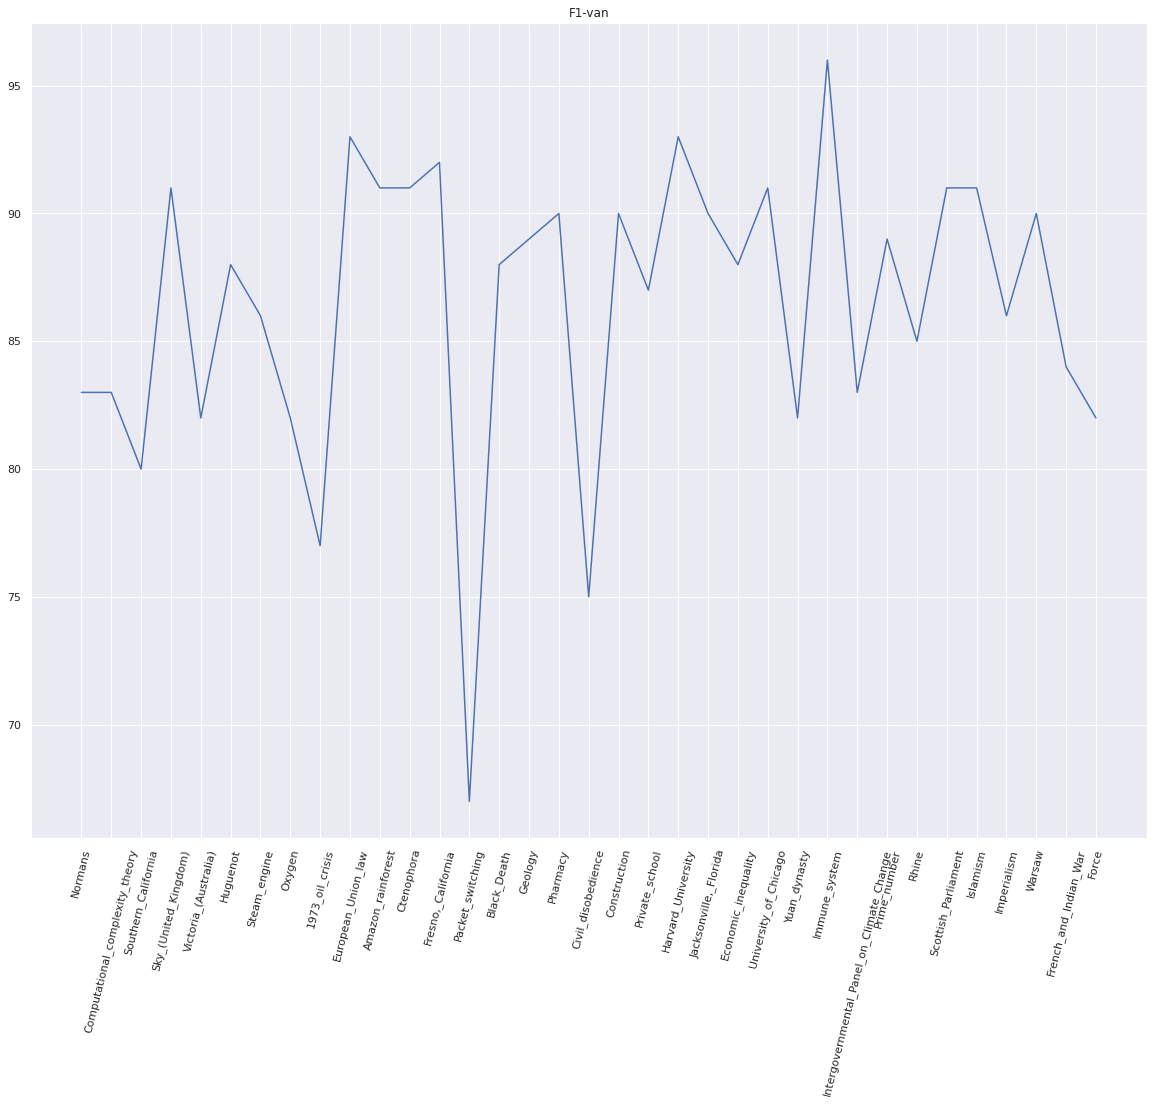

In [40]:
sns.set()
plt.title("F1-van")
x = score_df_van[0]
y = score_df_van['F1']
plt.plot(x, y)
plt.xticks(rotation=76)
# score_df['F1'].plot()
plt.gcf().set_size_inches(20, 15)
# plt.label

<AxesSubplot:title={'center':'EM-van'}, ylabel='EM'>

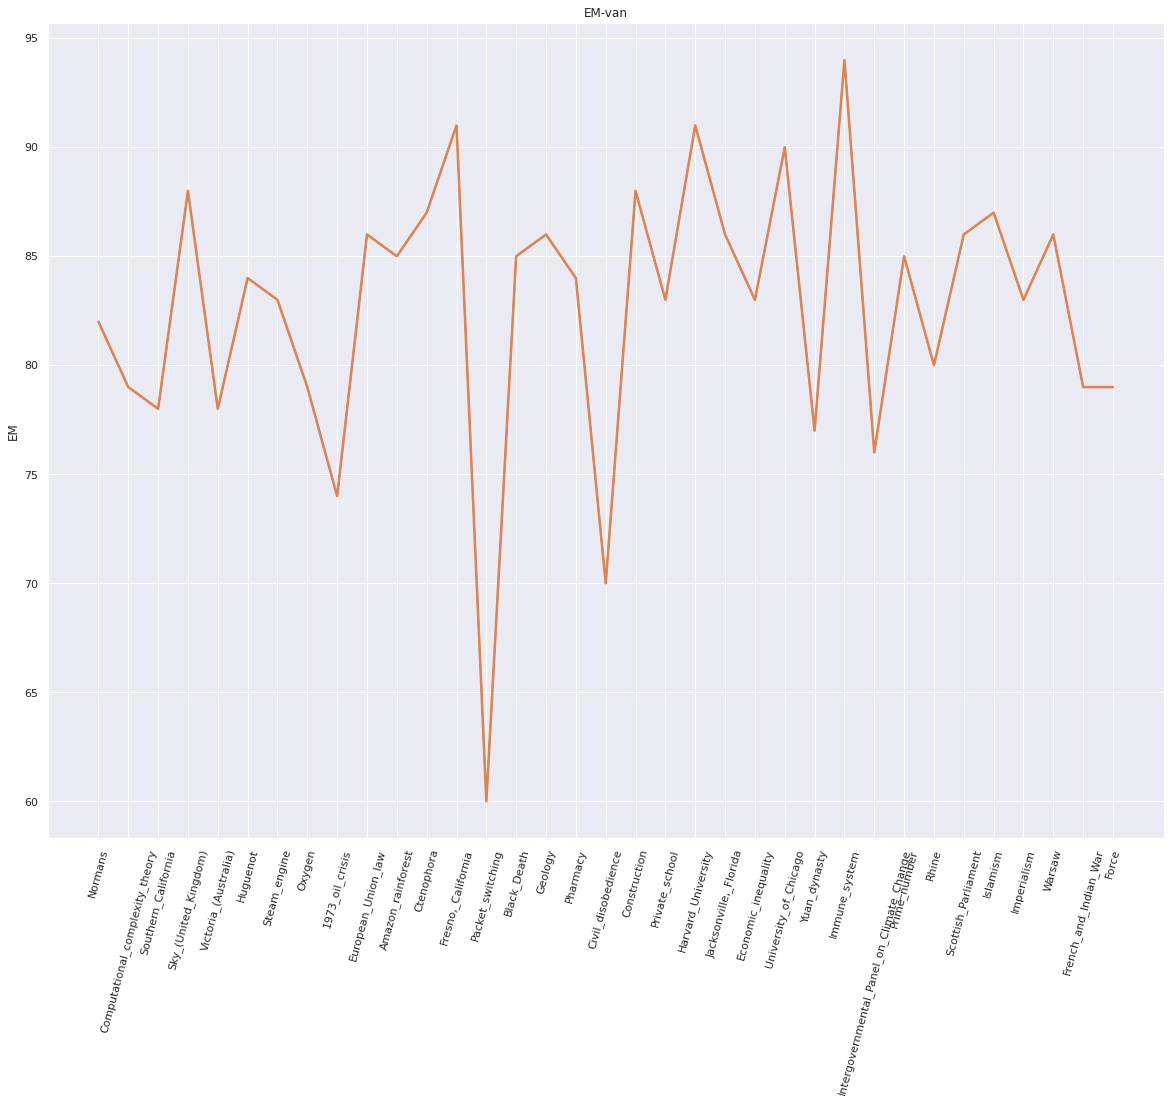

In [41]:
sns.set()
plt.title("EM-van")
x = score_df_van[0]
y = score_df_van['EM']
# score_df['EM'].plot()
plt.plot(x, y)
plt.xticks(rotation=75)
plt.gcf().set_size_inches(20, 15)
sns.lineplot(data=y, palette=['r'], linewidth=2.5)

In [42]:
# score_df = score_df[:35]

In [43]:
score_df_van

,0,F1,EM
0,Normans,83,82
1,Computational_complexity_theory,83,79
2,Southern_California,80,78
3,Sky_(United_Kingdom),91,88
4,Victoria_(Australia),82,78
5,Huguenot,88,84
6,Steam_engine,86,83
7,Oxygen,82,79
8,1973_oil_crisis,77,74
9,European_Union_law,93,86


In [44]:
score_df_van.rename(columns={'F1': 'F1-van',
                   'EM': 'EM-van'},
          inplace=True, errors='raise')

In [45]:
score_df = score_df.join(score_df_van['F1-van'])

In [46]:
score_df = score_df.join(score_df_van['EM-van'])

In [47]:
score_df

,0,F1,EM,F1-van,EM-van
0,Normans,84,83,83,82
1,Computational_complexity_theory,83,80,83,79
2,Southern_California,81,80,80,78
3,Sky_(United_Kingdom),92,89,91,88
4,Victoria_(Australia),82,78,82,78
5,Huguenot,88,85,88,84
6,Steam_engine,89,87,86,83
7,Oxygen,82,80,82,79
8,1973_oil_crisis,77,74,77,74
9,European_Union_law,93,86,93,86


In [48]:
score_df.to_csv('70_30_score_gen_theme_df.csv', index = False, encoding='utf-8')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(-5.0, 0, 'Islamism'),
  Text(0.0, 0, 'Normans'),
  Text(5.0, 0, 'Huguenot'),
  Text(10.0, 0, 'Amazon_rainforest'),
  Text(15.0, 0, 'Geology'),
  Text(20.0, 0, 'Harvard_University'),
  Text(25.0, 0, 'Immune_system'),
  Text(30.0, 0, 'Islamism'),
  Text(35.0, 0, ''),
  Text(40.0, 0, '')])

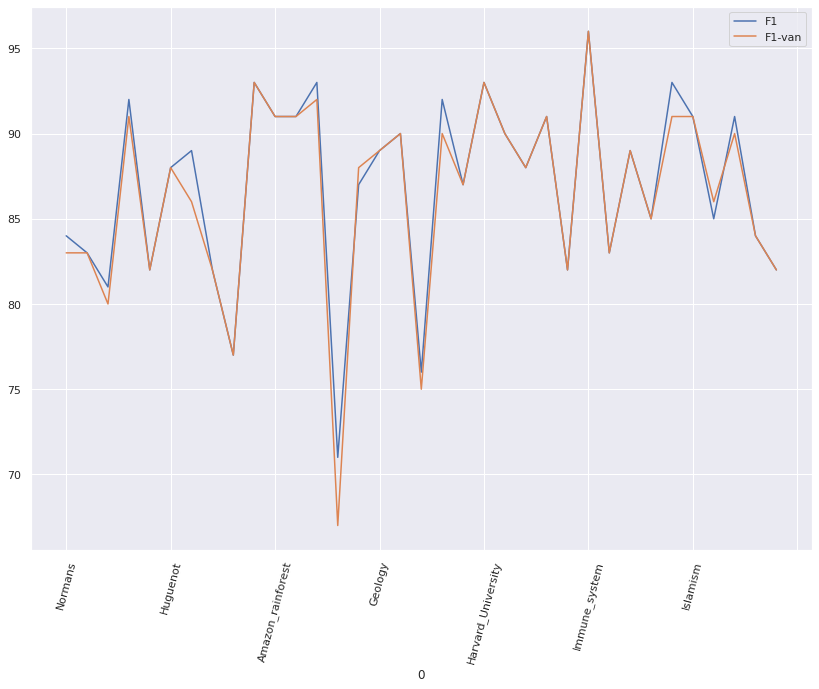

In [49]:
score_df.plot(x=0, y=["F1", "F1-van"], figsize=(14, 10))
plt.xticks(rotation=75)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(-5.0, 0, 'Islamism'),
  Text(0.0, 0, 'Normans'),
  Text(5.0, 0, 'Huguenot'),
  Text(10.0, 0, 'Amazon_rainforest'),
  Text(15.0, 0, 'Geology'),
  Text(20.0, 0, 'Harvard_University'),
  Text(25.0, 0, 'Immune_system'),
  Text(30.0, 0, 'Islamism'),
  Text(35.0, 0, ''),
  Text(40.0, 0, '')])

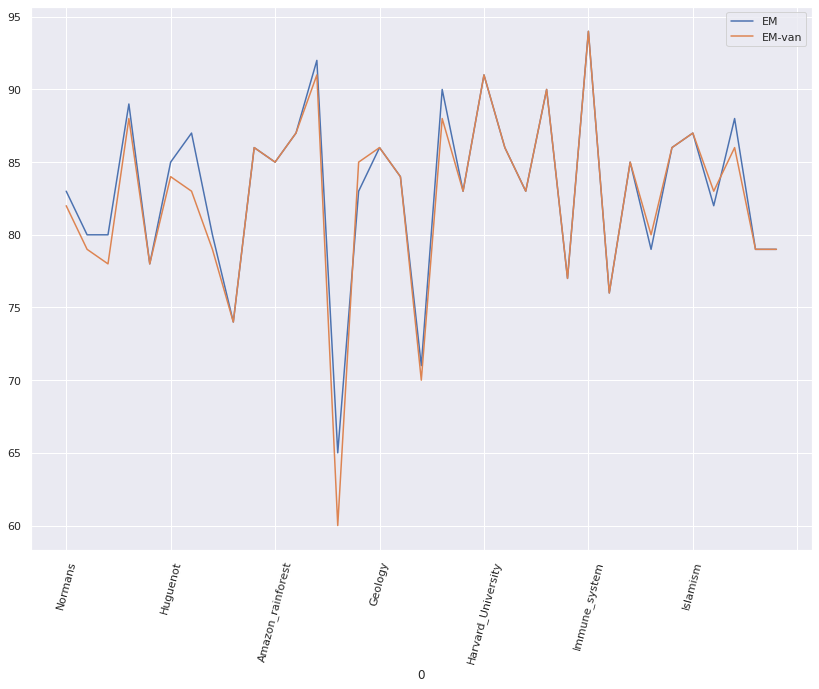

In [50]:
score_df.plot(x=0, y=["EM", "EM-van"], figsize=(14, 10))
plt.xticks(rotation=75)

In [51]:
score_df['F1'].mean()

86.88571428571429

In [52]:
score_df['F1-van'].mean()

86.45714285714286

In [53]:
score_df.mean()

F1        86.885714
EM        83.142857
F1-van    86.457143
EM-van    82.628571
dtype: float64

In [54]:
score_df.var()

F1        31.104202
EM        36.949580
F1-van    34.314286
EM-van    41.828571
dtype: float64